In [1]:
!mkdir -p data/house-prices

In [2]:
!unzip -o data/house-prices-advanced-regression-techniques.zip -d data/house-prices

Archive:  data/house-prices-advanced-regression-techniques.zip
  inflating: data/house-prices/data_description.txt  
  inflating: data/house-prices/sample_submission.csv  
  inflating: data/house-prices/test.csv  
  inflating: data/house-prices/train.csv  


In [3]:
import advertion
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

seed = np.random.RandomState(31337)

In [4]:
trainset = pd.read_csv("data/house-prices/train.csv")

trainset.shape

(1460, 81)

In [5]:
testset = pd.read_csv("data/house-prices/test.csv")

testset.shape

(1459, 80)

In [6]:
trainset.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
# keep only numerical features
X_train = trainset.select_dtypes(include=["number"]).copy()
X_test = testset.select_dtypes(include=["number"]).copy()

In [8]:
# drop target variable from our training dataset
X_train = X_train.drop(["SalePrice"], axis=1)

In [9]:
X_train["_adval_label_"] = 0.0

In [10]:
X_test["_adval_label_"] = 1.0

In [11]:
# combine training & test datasets
combined_dataset = pd.concat([X_train, X_test], axis=0, ignore_index=True)

combined_dataset.shape

(2919, 38)

In [12]:
combined_dataset.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', '_adval_label_'],
      dtype='object')

In [13]:
# shuffle it
combined_dataset_shuffled = combined_dataset.sample(frac=1)

In [14]:
X = combined_dataset_shuffled.drop(["_adval_label_"], axis=1)

In [15]:
y = combined_dataset_shuffled["_adval_label_"]

In [16]:
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
classifier = xgb.XGBClassifier()

  0%|          | 0/5 [00:00<?, ?it/s]

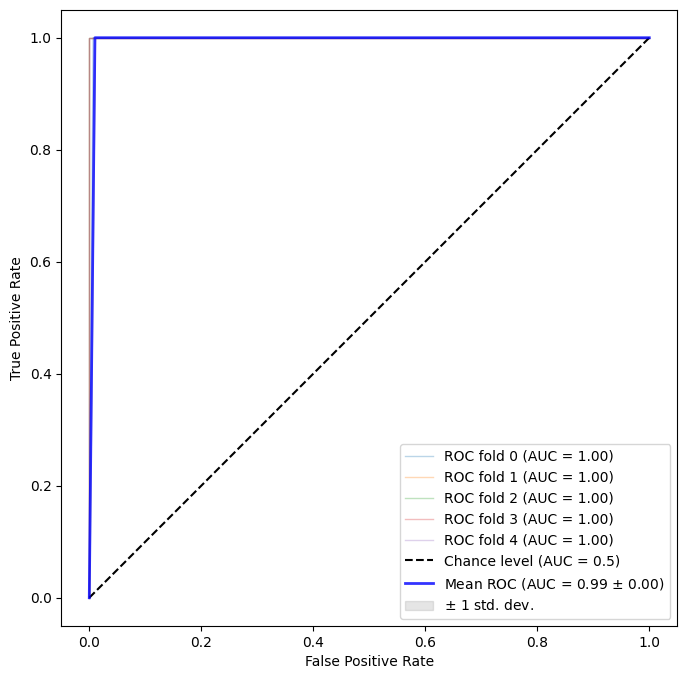

In [17]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8, 8))


for fold, (train, test) in tqdm([*enumerate(cv.split(X, y))]):
    classifier.fit(X.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.axis("square")
ax.legend(loc="best")
plt.show()

In [18]:
aucs

[0.9965753424657534, 1.0, 1.0, 1.0, 1.0]

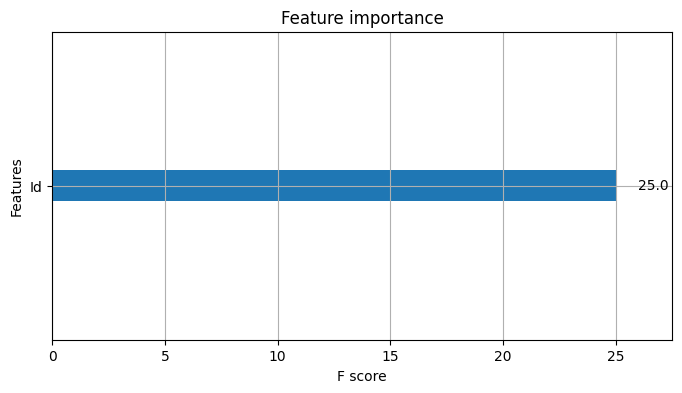

In [19]:
classifier = xgb.XGBClassifier(eval_metric="logloss")
classifier.fit(X, y)
fig, ax = plt.subplots(figsize=(8, 4))
xgb.plot_importance(classifier, ax=ax)
plt.show();

In [20]:
X = X.drop(["Id"], axis=1)

In [21]:
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
classifier = xgb.XGBClassifier()

  0%|          | 0/5 [00:00<?, ?it/s]

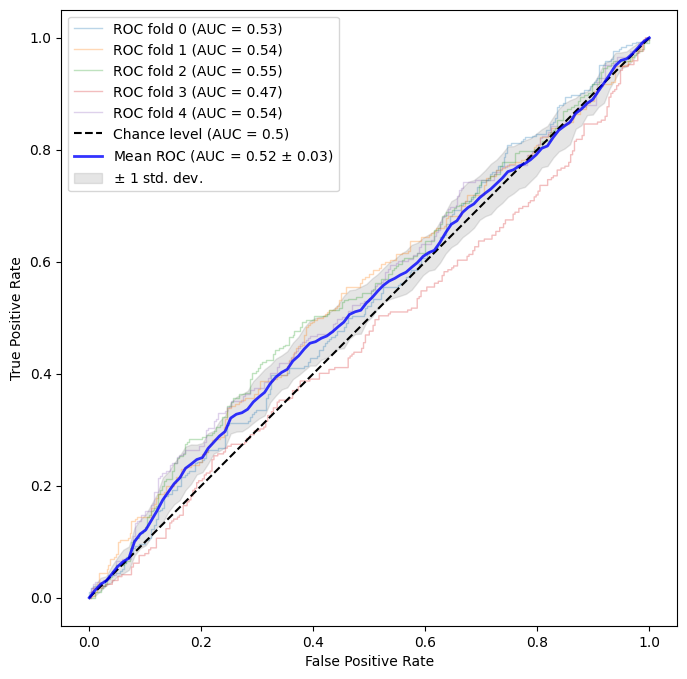

In [22]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8, 8))


for fold, (train, test) in tqdm([*enumerate(cv.split(X, y))]):
    classifier.fit(X.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.axis("square")
ax.legend(loc="best")
plt.show()

In [23]:
aucs

[0.5272447926440232,
 0.5413421842747232,
 0.5460100394070182,
 0.46835123850628635,
 0.5414371793061244]

### using the advertion package

In [24]:
advertion.validate(
    trainset=trainset,
    testset=testset,
    target="SalePrice",
)

INFO: Working only with available numerical features, categorical features are not yet supported.
INFO: Will try to identify adversarial features (see: https://advertion.readthedocs.io/en/0.1.0-alpha/adversarial-features)
INFO: Identified adversarial feature: [name: Id, statistic: 1.0, p-value: 0.0].
INFO: training and test datasets follow the same underlying distribution [mean ROC AUC: 0.517].


{'adversarial_features': ['Id'],
 'datasets_follow_same_distribution': True,
 'mean_roc_auc': 0.5172736111621621}